In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# a

In [79]:
train_data = np.load("train.npz")
test_data  = np.load("test.npz")

x_train, y_train = train_data['a'], train_data['b']
x_test,  y_test  = test_data['a'],  test_data['b']

In [80]:
x_train.shape

(80000, 28, 28)

In [81]:
x_train_flat = []

for x_train_item in x_train:
    x_train_flat.append(x_train_item.ravel())
    

x_train_flat = np.array(x_train_flat)

In [82]:
x = x_train_flat

In [83]:
x_mean = x.mean(axis=0)

In [84]:
x_normal = x - x_mean

In [85]:
x_cov = np.cov(x_normal.T)

In [86]:
w, v = np.linalg.eig(x_cov)

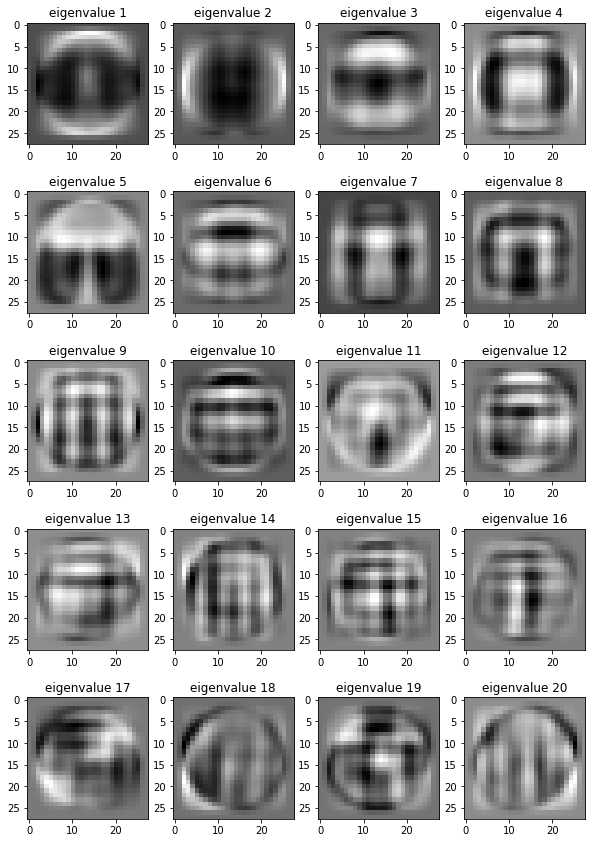

In [87]:
fig, ax = plt.subplots(5,4)
for i in range(20):
    ax[int(i/4)][i%4].imshow(v[:,i].reshape(28,28), cmap="gray")
    ax[int(i/4)][i%4].set_title(f"eigenvalue {i+1}")

fig.set_size_inches(10,15)
plt.show()

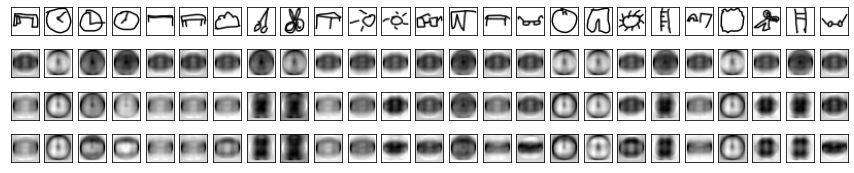

In [99]:
fig, ax = plt.subplots(4,25)
for i in range(25):
    ax[0][i].imshow(x_train[i], cmap="gray")
    ax[0][i].get_xaxis().set_visible(False)
    ax[0][i].get_yaxis().set_visible(False)
    
    for j in range(1,4):
        data_sample_reduced =  (x_train[i].ravel()-x_mean) @ np.linalg.pinv(v[:,:j]).T

        data_sample_reconstructed = data_sample_reduced @ v[:, :j].T + x_mean

        ax[j][i].imshow(data_sample_reconstructed.real.reshape(28,28), cmap="gray")
        ax[j][i].get_xaxis().set_visible(False)
        ax[j][i].get_yaxis().set_visible(False)
    
fig.set_size_inches(15,3)
plt.show()

# b